In [1]:
import os
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.4.0+cu121


In [2]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch==2.4.0

In [3]:
# Install torch geometric
if 'IS_GRADESCOPE_ENV' not in os.environ:
  torch_version = str(torch.__version__)
  scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  !pip install torch-scatter -f $scatter_src
  !pip install torch-sparse -f $sparse_src
  !pip install torch-geometric
  !pip install ogb

Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 55.6 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.9 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid

In [5]:
dataset = Planetoid(root="/datasets", name='Cora')

Processing...
Done!


In [6]:
data = dataset[0]

In [7]:
data # Cora dataset: Citation network dataset

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
data.x # Node feature matrix: [Nodes, feature_dimension]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [9]:
data.edge_index # Edge_list: Alternate to Adjacency matrix representation. Edge_list --> tensor([src_index_list, dest_index_list])

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

In [10]:
data.edge_index[0,:] # Source_index

tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706])

In [11]:
data.edge_index[1,:] # Destination_index

tensor([   0,    0,    0,  ..., 2707, 2707, 2707])

**Message Passing Layer**

In [36]:
class GraphSAGE_MessagePASSING(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()
    self.linear_self = torch.nn.Linear(input_dim, hidden_dim)
    self.linear_neigh = torch.nn.Linear(input_dim, hidden_dim)

  def message(self, x, edge_list):
    src_nodes = edge_list[0,:]
    src_messages = x[src_nodes] # [num-edges, hidden-dim]

    return src_messages

  def Aggregate(self, x, edge_list):
    src_nodes = edge_list[0,:]
    dest_nodes = edge_list[1,:]

    src_messages = self.message(x, edge_list)

    neighbor_message_list = []

    for dest_index in range(x.shape[0]): # Iterating overall destination nodes
      # Finding all the source nodes for a particular destination node by comparing destination index in edge_list
      src_nodes_index = torch.where(dest_index == dest_nodes)[0]
      # Getting only the source messages for the current destination node which shares an edge with source nodes.
      src_node_messages = src_messages[src_nodes_index]

      src_message_sum = src_node_messages.sum(dim=0) if src_node_messages.shape[0] > 1 else src_node_messages.squeeze(0)
      neighbor_message_list.append(src_message_sum) # Append the Aggregated neighbourhood information of the current destination node

    neighbor_aggregated = torch.stack(neighbor_message_list)
    return neighbor_aggregated

  def forward(self, x, edge_list):
    neigh_aggregated = self.Aggregate(x, edge_list)
    neigh_embedd = self.linear_neigh(neigh_aggregated)

    node_self = self.linear_self(x)
    out = neigh_embedd+node_self
    out = F.normalize(out, dim=1, p=2)

    return out


In [37]:
torch.where(data.edge_index[1,:] == 0)[0]

tensor([0, 1, 2])

In [38]:
data.x[data.edge_index[0,:]][torch.where(data.edge_index[1,:] == 55)[0]] # Example of src_message_

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [66]:
class GNNModel(torch.nn.Module):
  def __init__(self, hidden_dim, in_dim = dataset.num_node_features, out_dim = dataset.num_classes):
    super().__init__()
    self.conv1 = GraphSAGE_MessagePASSING(in_dim, hidden_dim)
    self.conv2 = GraphSAGE_MessagePASSING(hidden_dim, out_dim)

  def forward(self, x: torch.tensor, edge_list: torch.tensor):
    x = self.conv1(x, edge_list)
    x = F.relu(x)
    x = F.dropout(x, p=0.15, training=self.training)

    x = self.conv2(x, edge_list)

    return x

In [67]:
model = GNNModel(hidden_dim=128)
model

GNNModel(
  (conv1): GraphSAGE_MessagePASSING(
    (linear_self): Linear(in_features=1433, out_features=128, bias=True)
    (linear_neigh): Linear(in_features=1433, out_features=128, bias=True)
  )
  (conv2): GraphSAGE_MessagePASSING(
    (linear_self): Linear(in_features=128, out_features=7, bias=True)
    (linear_neigh): Linear(in_features=128, out_features=7, bias=True)
  )
)

In [68]:
optimizer = torch.optim.Adagrad(model.parameters(), lr = 0.05, weight_decay=25e-5)
criterion = torch.nn.CrossEntropyLoss()

In [69]:
def train():
  model.train()
  optimizer.zero_grad()
  output = model(data.x, data.edge_index)
  loss = criterion(output[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss.item()

In [70]:
def test():
  model.eval()
  pred =model(data.x, data.edge_index)
  pred = pred.argmax(dim=1)
  train_acc = (pred[data.train_mask] == data.y[data.train_mask]).sum() / data.train_mask.sum()
  val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum() / data.val_mask.sum()
  test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()

  return train_acc, val_acc, test_acc

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(8,8))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

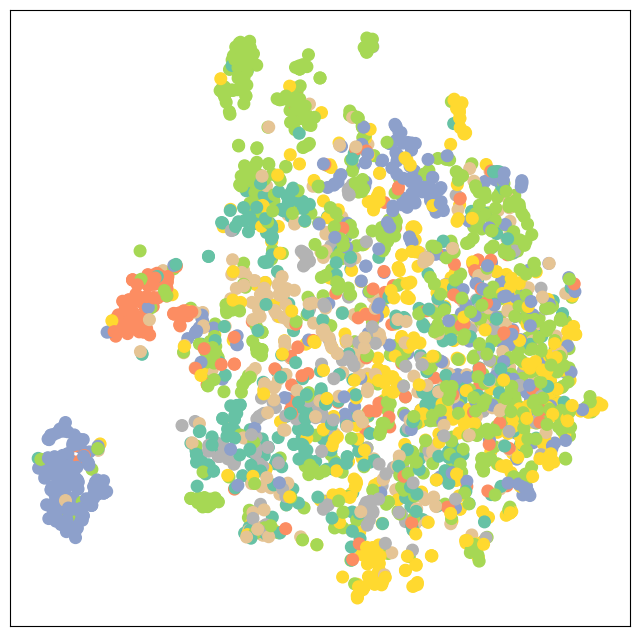

In [72]:
model.eval()

x = model(data.x, data.edge_index)
visualize(x, color=data.y)

In [73]:
for i in range(50):
  loss = train()
  train_acc, val_acc, test_acc = test()
  print(f"Epoch: {i:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch: 000, Loss: 1.9249, Train Acc: 0.3857, Val Acc: 0.3800, Test Acc: 0.3950
Epoch: 001, Loss: 35.0669, Train Acc: 0.4143, Val Acc: 0.3820, Test Acc: 0.4010
Epoch: 002, Loss: 59.2621, Train Acc: 0.5357, Val Acc: 0.3280, Test Acc: 0.3130
Epoch: 003, Loss: 23.2639, Train Acc: 0.5214, Val Acc: 0.3180, Test Acc: 0.3280
Epoch: 004, Loss: 6.3670, Train Acc: 0.9214, Val Acc: 0.7020, Test Acc: 0.7430
Epoch: 005, Loss: 0.6653, Train Acc: 0.9571, Val Acc: 0.6520, Test Acc: 0.6530
Epoch: 006, Loss: 0.9202, Train Acc: 0.9929, Val Acc: 0.7160, Test Acc: 0.7230
Epoch: 007, Loss: 0.6244, Train Acc: 0.9857, Val Acc: 0.7280, Test Acc: 0.7540
Epoch: 008, Loss: 0.4736, Train Acc: 0.9857, Val Acc: 0.7360, Test Acc: 0.7770
Epoch: 009, Loss: 0.0685, Train Acc: 0.9857, Val Acc: 0.7440, Test Acc: 0.7650
Epoch: 010, Loss: 0.1901, Train Acc: 1.0000, Val Acc: 0.7440, Test Acc: 0.7690
Epoch: 011, Loss: 0.0655, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7550
Epoch: 012, Loss: 0.0314, Train Acc: 1.0000, Val 

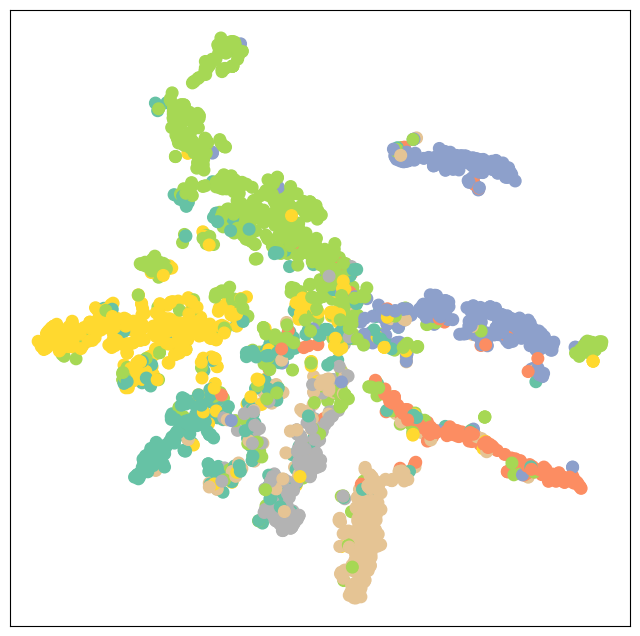

In [74]:
# Visualization after the model is trained
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)